In [4]:
pip install xgboost

^C
Note: you may need to restart the kernel to use updated packages.


Defaulting to user installation because normal site-packages is not writeable


In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
import xgboost as xgb
from xgboost import plot_importance
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_theme(style="whitegrid")

def load_data(file_path='all_features.csv'):
    """Load the feature data from CSV file."""
    try:
        df = pd.read_csv(file_path)
        print(f"Successfully loaded data with {df.shape[0]} rows and {df.shape[1]} columns.")
        return df
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

def preprocess_data(df):
    """Preprocess the data for XGBoost."""
    # Make a copy to avoid modifying the original DataFrame
    df_processed = df.copy()
    
    # Extract target variable from char_name column
    target = df_processed['char_name']
    
    # Remove non-feature columns
    features = df_processed.drop(['file_name', 'char_name'], axis=1)
    
    # Handle missing values
    features = features.fillna(features.mean())
    
    # Encode target labels
    label_encoder = LabelEncoder()
    target_encoded = label_encoder.fit_transform(target)
    
    print(f"Data preprocessed: {features.shape[1]} features available.")
    print(f"Target classes: {label_encoder.classes_}")
    
    return features, target_encoded, label_encoder.classes_

def train_xgboost_model(X_train, y_train, X_test, y_test):
    """Train an XGBoost classifier."""
    # Initialize the XGBoost classifier
    xgb_clf = xgb.XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='multi:softprob',
        random_state=42,
        use_label_encoder=False,
        eval_metric='mlogloss'
    )
    
    # Train the model
    xgb_clf.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=10,
        verbose=True
    )
    
    # Plot and save learning curves
    results = xgb_clf.evals_result()
    epochs = len(results['validation_0']['mlogloss'])
    x_axis = range(0, epochs)
    
    plt.figure(figsize=(12, 8))
    plt.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
    plt.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
    plt.legend()
    plt.title('XGBoost Log Loss', fontsize=16)
    plt.xlabel('Number of Boosting Rounds', fontsize=14)
    plt.ylabel('Log Loss', fontsize=14)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('xgboost_learning_curve.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    return xgb_clf

def evaluate_model(model, X_test, y_test, class_names):
    """Evaluate the XGBoost model performance."""
    # Make predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    
    # Print classification report
    print("\nClassification Report:")
    report = classification_report(y_test, y_pred, target_names=class_names)
    print(report)
    
    # Save classification report as an image
    plt.figure(figsize=(10, 6))
    plt.text(0.01, 0.99, f"Accuracy: {accuracy:.4f}\n\n" + report, va='top', ha='left', fontsize=12)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('xgboost_classification_report.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix', fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.savefig('xgboost_confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # Calculate multi-class ROC AUC
    roc_auc = {}
    n_classes = len(class_names)
    
    if n_classes <= 10:  # Only plot ROC curves if there are not too many classes
        plt.figure(figsize=(12, 10))
        
        for i in range(n_classes):
            # For each class, calculate the ROC curve and ROC area
            fpr, tpr, _ = roc_curve((y_test == i).astype(int), y_prob[:, i])
            roc_auc[i] = auc(fpr, tpr)
            
            # Plot ROC curve for the class
            plt.plot(fpr, tpr, lw=2, 
                     label=f'ROC curve of class {class_names[i]} (area = {roc_auc[i]:.2f})')
        
        # Plot the diagonal reference line
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate', fontsize=12)
        plt.ylabel('True Positive Rate', fontsize=12)
        plt.title('Multi-class ROC Curves', fontsize=16)
        plt.legend(loc="lower right")
        plt.tight_layout()
        plt.savefig('xgboost_roc_curves.png', dpi=300, bbox_inches='tight')
        plt.close()
    
    return accuracy, y_pred, y_prob

def plot_feature_importance(model, feature_names):
    """Plot feature importance from XGBoost model."""
    # Get feature importance from the model (weight, gain, cover)
    importance_types = ['weight', 'gain', 'cover']
    
    for importance_type in importance_types:
        # Plot feature importance using xgboost's built-in function
        plt.figure(figsize=(12, 10))
        plot_importance(model, importance_type=importance_type, max_num_features=30, 
                       title=f'XGBoost Feature Importance ({importance_type})',
                       xlabel='F Score', grid=False)
        plt.tight_layout()
        plt.savefig(f'xgboost_importance_{importance_type}.png', dpi=300, bbox_inches='tight')
        plt.close()
        
        # Plot feature importance as a bar chart (more customizable)
        importance = model.get_booster().get_score(importance_type=importance_type)
        importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
        
        features = [x[0] for x in importance[:30]]
        scores = [x[1] for x in importance[:30]]
        
        plt.figure(figsize=(12, 10))
        plt.barh(range(len(scores)), scores, align='center')
        plt.yticks(range(len(scores)), features)
        plt.title(f'XGBoost Top 30 Feature Importance ({importance_type})', fontsize=16)
        plt.xlabel('Importance', fontsize=12)
        plt.gca().invert_yaxis()  # Display the highest scores at the top
        plt.tight_layout()
        plt.savefig(f'xgboost_top_features_{importance_type}.png', dpi=300, bbox_inches='tight')
        plt.close()
    
    # Get feature importance (using 'gain' as default)
    importance = model.get_booster().get_score(importance_type='gain')
    importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
    
    # Return top 30 important features
    return importance[:30]

def plot_feature_distributions(features, target, target_names, top_features):
    """Plot distributions of top features by class."""
    # Get the feature names from the top features list
    top_feature_names = [feat[0] for feat in top_features[:10]]  # Take top 10
    
    # Create a figure for the distribution plots
    fig, axes = plt.subplots(5, 2, figsize=(20, 25))
    axes = axes.flatten()
    
    # Create a DataFrame with features and target
    df = pd.DataFrame(features)
    df.columns = features.columns
    df['target'] = target
    
    # Plot distribution for each top feature
    for i, feature in enumerate(top_feature_names):
        if i >= 10:  # Limit to 10 features
            break
            
        if feature in df.columns:
            sns.boxplot(x='target', y=feature, data=df, ax=axes[i])
            axes[i].set_title(f'Distribution of {feature}', fontsize=14)
            axes[i].set_xlabel('Class', fontsize=12)
            axes[i].set_ylabel(feature, fontsize=12)
            axes[i].set_xticklabels([target_names[j] for j in range(len(target_names))], rotation=45)
    
    plt.tight_layout()
    plt.savefig('xgboost_feature_distributions.png', dpi=300, bbox_inches='tight')
    plt.close()

def tune_hyperparameters(X_train, y_train):
    """Tune hyperparameters for XGBoost using GridSearchCV."""
    print("Starting hyperparameter tuning (this may take some time)...")
    
    # Define the parameter grid
    param_grid = {
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'n_estimators': [50, 100, 200],
        'subsample': [0.7, 0.8, 0.9],
        'colsample_bytree': [0.7, 0.8, 0.9],
        'gamma': [0, 0.1, 0.2]
    }
    
    # Initialize the XGBoost classifier
    xgb_clf = xgb.XGBClassifier(
        objective='multi:softprob',
        random_state=42,
        use_label_encoder=False,
        eval_metric='mlogloss'
    )
    
    # Set up cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Set up GridSearchCV
    grid_search = GridSearchCV(
        estimator=xgb_clf,
        param_grid=param_grid,
        scoring='accuracy',
        cv=cv,
        verbose=2,
        n_jobs=-1
    )
    
    # Fit the grid search
    grid_search.fit(X_train, y_train)
    
    # Print the best parameters and score
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")
    
    # Save hyperparameter tuning results as an image
    plt.figure(figsize=(12, 8))
    plt.text(0.01, 0.99, f"Best Parameters:\n{grid_search.best_params_}\n\nBest CV Score: {grid_search.best_score_:.4f}",
             va='top', ha='left', fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('xgboost_hyperparameter_tuning.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    return grid_search.best_params_, grid_search.best_score_

def visualize_tree(model, output_file='xgboost_tree.png'):
    """Visualize the first tree in the XGBoost model."""
    try:
        # Get the first tree dump
        dump = model.get_booster().get_dump()[0]
        
        # Save tree visualization using xgboost's plot_tree
        plt.figure(figsize=(20, 15))
        xgb.plot_tree(model, num_trees=0)
        plt.title('First Decision Tree in XGBoost Model', fontsize=16)
        plt.tight_layout()
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        plt.close()
        print(f"Tree visualization saved to {output_file}")
    except Exception as e:
        print(f"Error visualizing tree: {e}")

def save_feature_importance_table(importance, output_file='xgboost_feature_importance.csv'):
    """Save feature importance as a CSV file and image."""
    # Create a DataFrame from the importance dictionary
    importance_df = pd.DataFrame({
        'Feature': [item[0] for item in importance],
        'Importance': [item[1] for item in importance]
    })
    
    # Save to CSV
    importance_df.to_csv(output_file, index=False)
    print(f"Feature importance table saved to {output_file}")
    
    # Save top 20 feature importance as image
    plt.figure(figsize=(10, 8))
    importance_table = importance_df.head(20).to_string(index=False)
    plt.text(0.01, 0.99, "Top 20 Features by Importance:\n\n" + importance_table, 
             va='top', ha='left', fontsize=12, family='monospace')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('xgboost_feature_importance_table.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    return importance_df

def main():
    """Main function to run the XGBoost analysis."""
    print("Starting XGBoost analysis for time-series data...")
    
    # Create a summary image to capture console output
    console_output = []
    console_output.append("XGBoost Analysis for Time-Series Data\n")
    console_output.append("====================================\n")
    
    # Load the data
    df = load_data()
    if df is None:
        return
    
    console_output.append(f"Data loaded: {df.shape[0]} samples, {df.shape[1]} columns\n")
    
    # Preprocess the data
    features, target_encoded, class_names = preprocess_data(df)
    console_output.append(f"Preprocessed data: {features.shape[1]} features\n")
    console_output.append(f"Target classes: {', '.join(class_names)}\n")
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        features, target_encoded, test_size=0.25, random_state=42, stratify=target_encoded
    )
    
    console_output.append(f"Training set: {X_train.shape[0]} samples\n")
    console_output.append(f"Testing set: {X_test.shape[0]} samples\n")
    
    # Uncomment to run hyperparameter tuning (time-consuming)
    # best_params, best_score = tune_hyperparameters(X_train, y_train)
    # console_output.append(f"Best parameters: {best_params}\n")
    # console_output.append(f"Best CV score: {best_score:.4f}\n")
    
    # Train the XGBoost model
    console_output.append("\nTraining XGBoost model...\n")
    xgb_model = train_xgboost_model(X_train, y_train, X_test, y_test)
    console_output.append("XGBoost model trained successfully\n")
    
    # Evaluate the model
    console_output.append("\nEvaluating model performance...\n")
    accuracy, y_pred, y_prob = evaluate_model(xgb_model, X_test, y_test, class_names)
    console_output.append(f"Test accuracy: {accuracy:.4f}\n")
    
    # Plot and save feature importance
    console_output.append("\nAnalyzing feature importance...\n")
    importance = plot_feature_importance(xgb_model, features.columns)
    
    # Plot distributions of top features
    plot_feature_distributions(features, target_encoded, class_names, importance)
    
    # Visualize a tree from the model
    visualize_tree(xgb_model)
    
    # Save feature importance to CSV and as image
    importance_df = save_feature_importance_table(importance)
    
    # Calculate cross-validation score
    cv_scores = cross_val_score(xgb_model, features, target_encoded, cv=5, scoring='accuracy')
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()
    console_output.append(f"\n5-fold Cross-validation Accuracy: {cv_mean:.4f} (+/- {cv_std * 2:.4f})\n")
    
    # Save the model
    model_filename = 'xgboost_model.json'
    xgb_model.save_model(model_filename)
    console_output.append(f"\nModel saved to '{model_filename}'\n")
    
    console_output.append("\nXGBoost analysis completed successfully!")
    
    # Save console output as image
    plt.figure(figsize=(12, 10))
    plt.text(0.01, 0.99, "".join(console_output), va='top', ha='left', fontsize=12, family='monospace')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('xgboost_analysis_summary.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    return xgb_model, importance_df

if __name__ == "__main__":
    main()

Starting XGBoost analysis for time-series data...
Successfully loaded data with 283 rows and 109 columns.
Data preprocessed: 107 features available.
Target classes: ['অ_36606b04_Right Hand_20250423_120617_preprocessed'
 'অ_36606b04_Right Hand_20250423_120731_preprocessed'
 'আ_36606b04_Right Hand_20250423_120748_preprocessed'
 'আ_36606b04_Right Hand_20250423_120805_preprocessed'
 'ক_01083526_Right Hand_20250423_122648_preprocessed'
 'ক_01083526_Right Hand_20250423_122659_preprocessed'
 'ক_01083526_Right Hand_20250423_122711_preprocessed'
 'ক_041c8727_Right Hand_20250425_143649_preprocessed'
 'ক_041c8727_Right Hand_20250425_143657_preprocessed'
 'ক_0e4e9ee0_Right Hand_20250426_005722_preprocessed'
 'ক_0e4e9ee0_Right Hand_20250426_005730_preprocessed'
 'ক_117fb6fc_Right Hand_20250423_122340_preprocessed'
 'ক_117fb6fc_Right Hand_20250423_122352_preprocessed'
 'ক_1703ad9a_Right Hand_20250425_144058_preprocessed'
 'ক_1703ad9a_Right Hand_20250425_144107_preprocessed'
 'ক_1703ad9a_Right Hand_2

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

In [3]:
import pandas as pd
from xgboost import XGBClassifier, plot_importance
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Step 1: Load your CSV
df = pd.read_csv("all_features.csv")  # Make sure path is correct

# Step 2: Separate features and target
X = df.drop(columns=["file_name", "char_name"])  # drop non-feature columns
y = df["char_name"]  # target = alphabet name

# Step 3: Encode target labels (e.g., অ → 0, গ → 1, etc.)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Step 4: Drop classes with fewer than 2 samples
value_counts = pd.Series(y_encoded).value_counts()
valid_classes = value_counts[value_counts >= 2].index

# Apply mask using Pandas Series to avoid error
mask = pd.Series(y_encoded).isin(valid_classes)
X = X[mask]
y_encoded = y_encoded[mask]

# Step 5: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.25, random_state=42, stratify=y_encoded
)

# Step 6: Train the XGBoost model
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_train, y_train)

# Step 7: Plot feature importance
plt.figure(figsize=(12, 6))
plot_importance(model, max_num_features=20, importance_type='gain')
plt.title("XGBoost Feature Importance (Top 20 Features)")
plt.tight_layout()
plt.show()

ValueError: With n_samples=0, test_size=0.25 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

              precision    recall  f1-score   support

           অ       0.00      0.00      0.00         1
           ক       0.90      0.75      0.82        12
           খ       0.60      0.82      0.69        11
           গ       0.69      0.82      0.75        11
           ঘ       1.00      0.64      0.78        11
           ঙ       0.83      0.91      0.87        11

    accuracy                           0.77        57
   macro avg       0.67      0.66      0.65        57
weighted avg       0.79      0.77      0.77        57



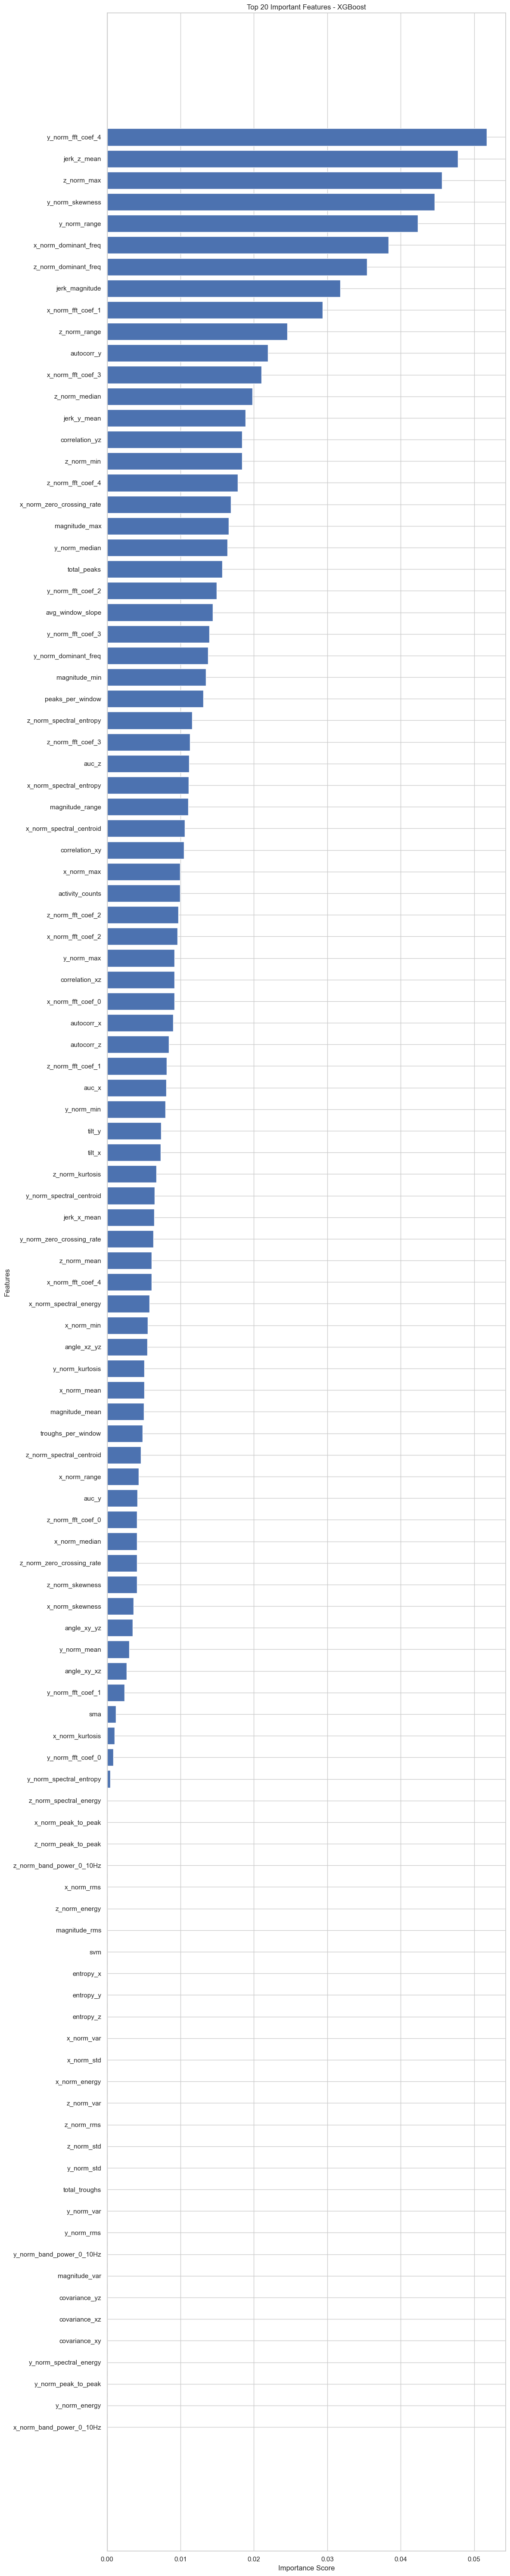

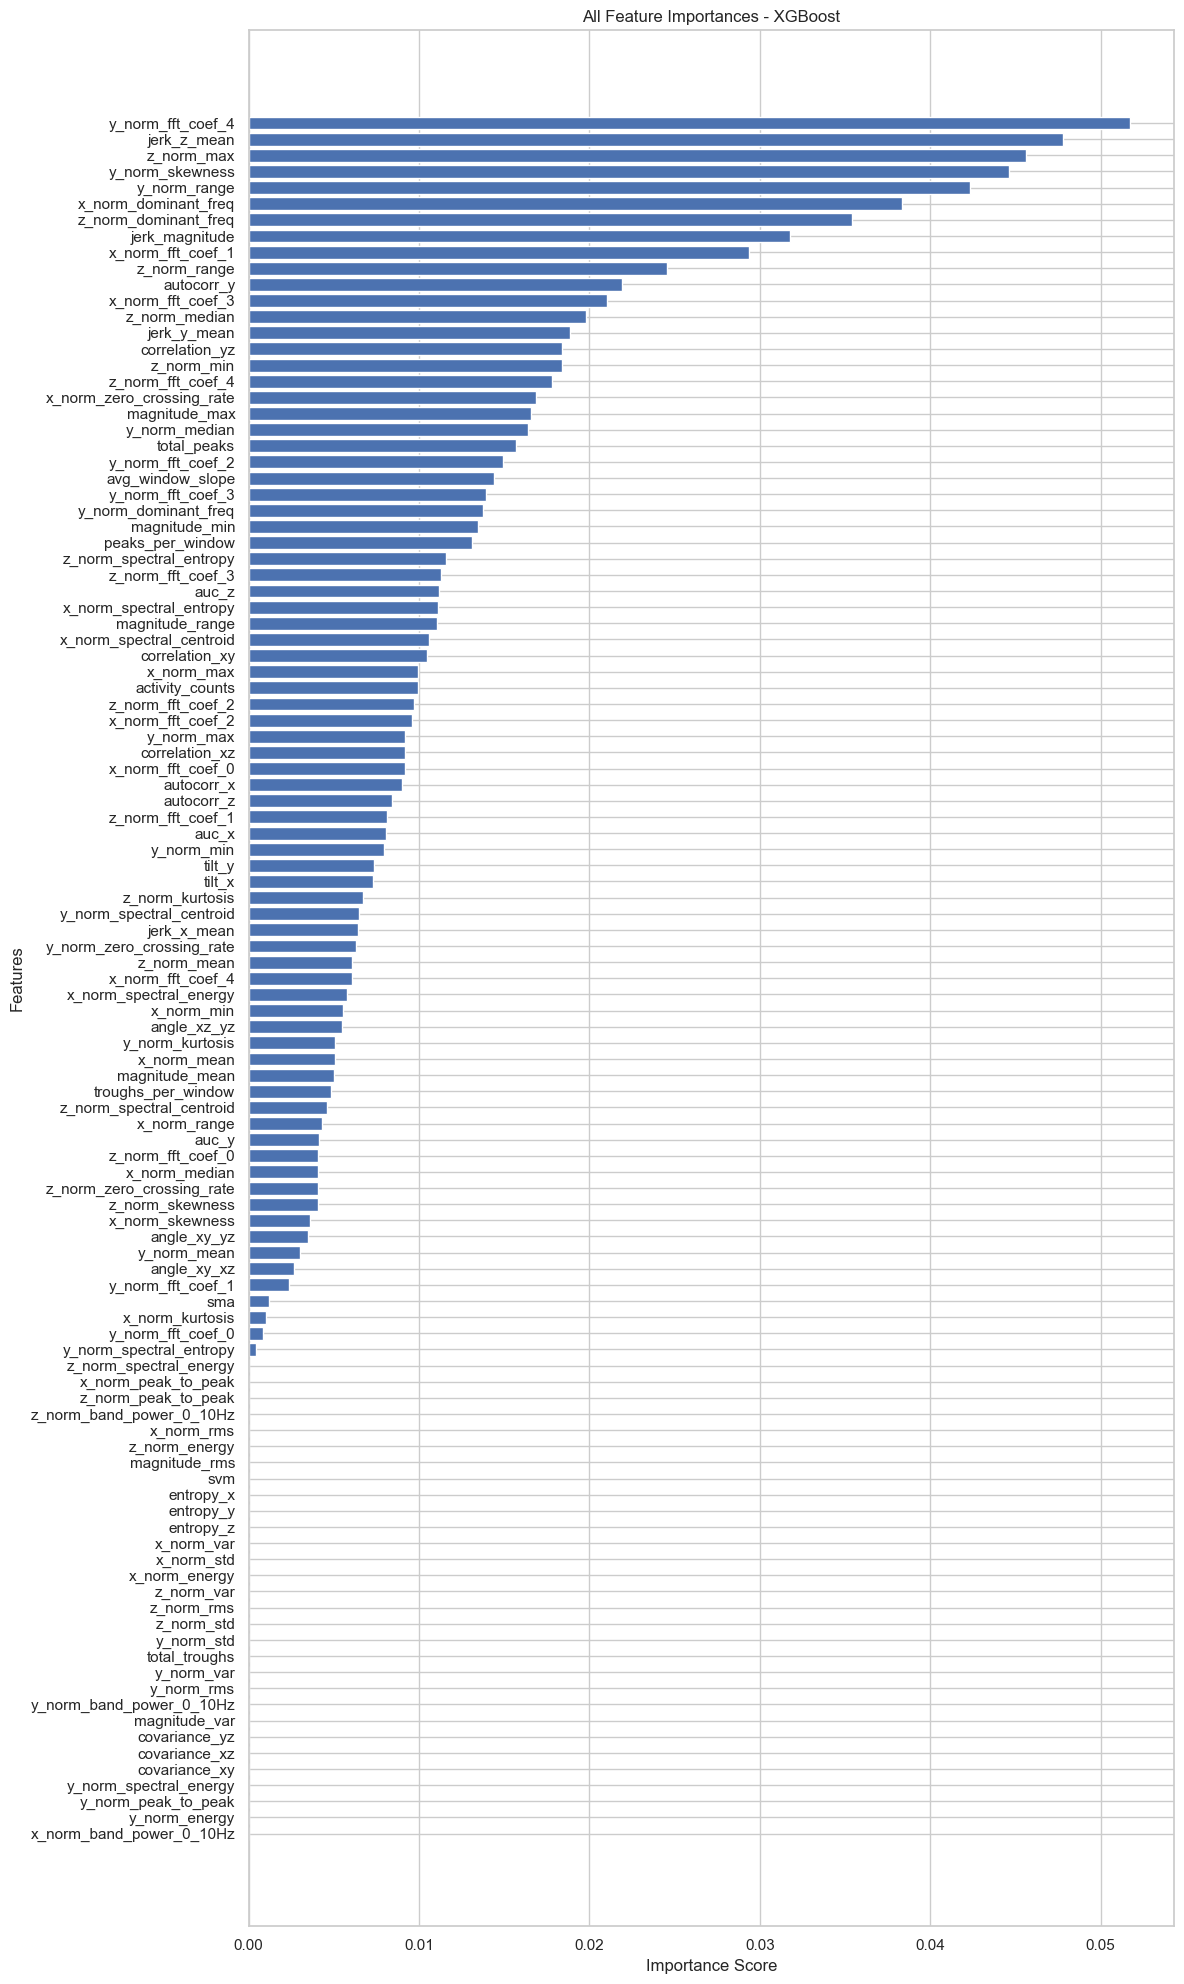


Top 20 Features:
                  Feature  Importance
        y_norm_fft_coef_4    0.051718
              jerk_z_mean    0.047793
               z_norm_max    0.045643
          y_norm_skewness    0.044597
             y_norm_range    0.042340
     x_norm_dominant_freq    0.038338
     z_norm_dominant_freq    0.035433
           jerk_magnitude    0.031768
        x_norm_fft_coef_1    0.029346
             z_norm_range    0.024528
               autocorr_y    0.021932
        x_norm_fft_coef_3    0.021051
            z_norm_median    0.019802
              jerk_y_mean    0.018885
           correlation_yz    0.018387
               z_norm_min    0.018379
        z_norm_fft_coef_4    0.017820
x_norm_zero_crossing_rate    0.016853
            magnitude_max    0.016554
            y_norm_median    0.016371


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# Load the dataset
df = pd.read_csv('all_features.csv')

# Extract character names from file names
df['character'] = df['file_name'].str.split('_').str[0]

# Encode the target variable (character)
label_encoder = LabelEncoder()
df['target'] = label_encoder.fit_transform(df['character'])

# Prepare features and target
X = df.drop(['file_name', 'char_name', 'character', 'target'], axis=1)
y = df['target']

# Split data into train and test sets - using stratification to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y  # This ensures all classes are represented in both sets
)

# Initialize and train XGBoost model
model = XGBClassifier(
    objective='multi:softprob',
    num_class=len(np.unique(y)),
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)

# Get the unique classes present in y_test
present_labels = np.unique(y_test)
present_target_names = label_encoder.inverse_transform(present_labels)

print(classification_report(
    y_test, 
    y_pred, 
    target_names=present_target_names,
    labels=present_labels
))

# Get feature importance
importance = model.feature_importances_

# Create a DataFrame for feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importance
})

# Sort features by importance
feature_importance = feature_importance.sort_values('Importance', ascending=False)

# Plot top 20 features
plt.figure(figsize=(12, 60))
plt.barh(feature_importance['Feature'][:], feature_importance['Importance'][:])
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Top 20 Important Features - XGBoost')
plt.gca().invert_yaxis()  # Most important at top
plt.tight_layout()

# Save the plot
plt.savefig('xgboost_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot all features (smaller font)
plt.figure(figsize=(12, 20))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('All Feature Importances - XGBoost')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('xgboost_all_features_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# Print top features
print("\nTop 20 Features:")
print(feature_importance.head(20).to_string(index=False))

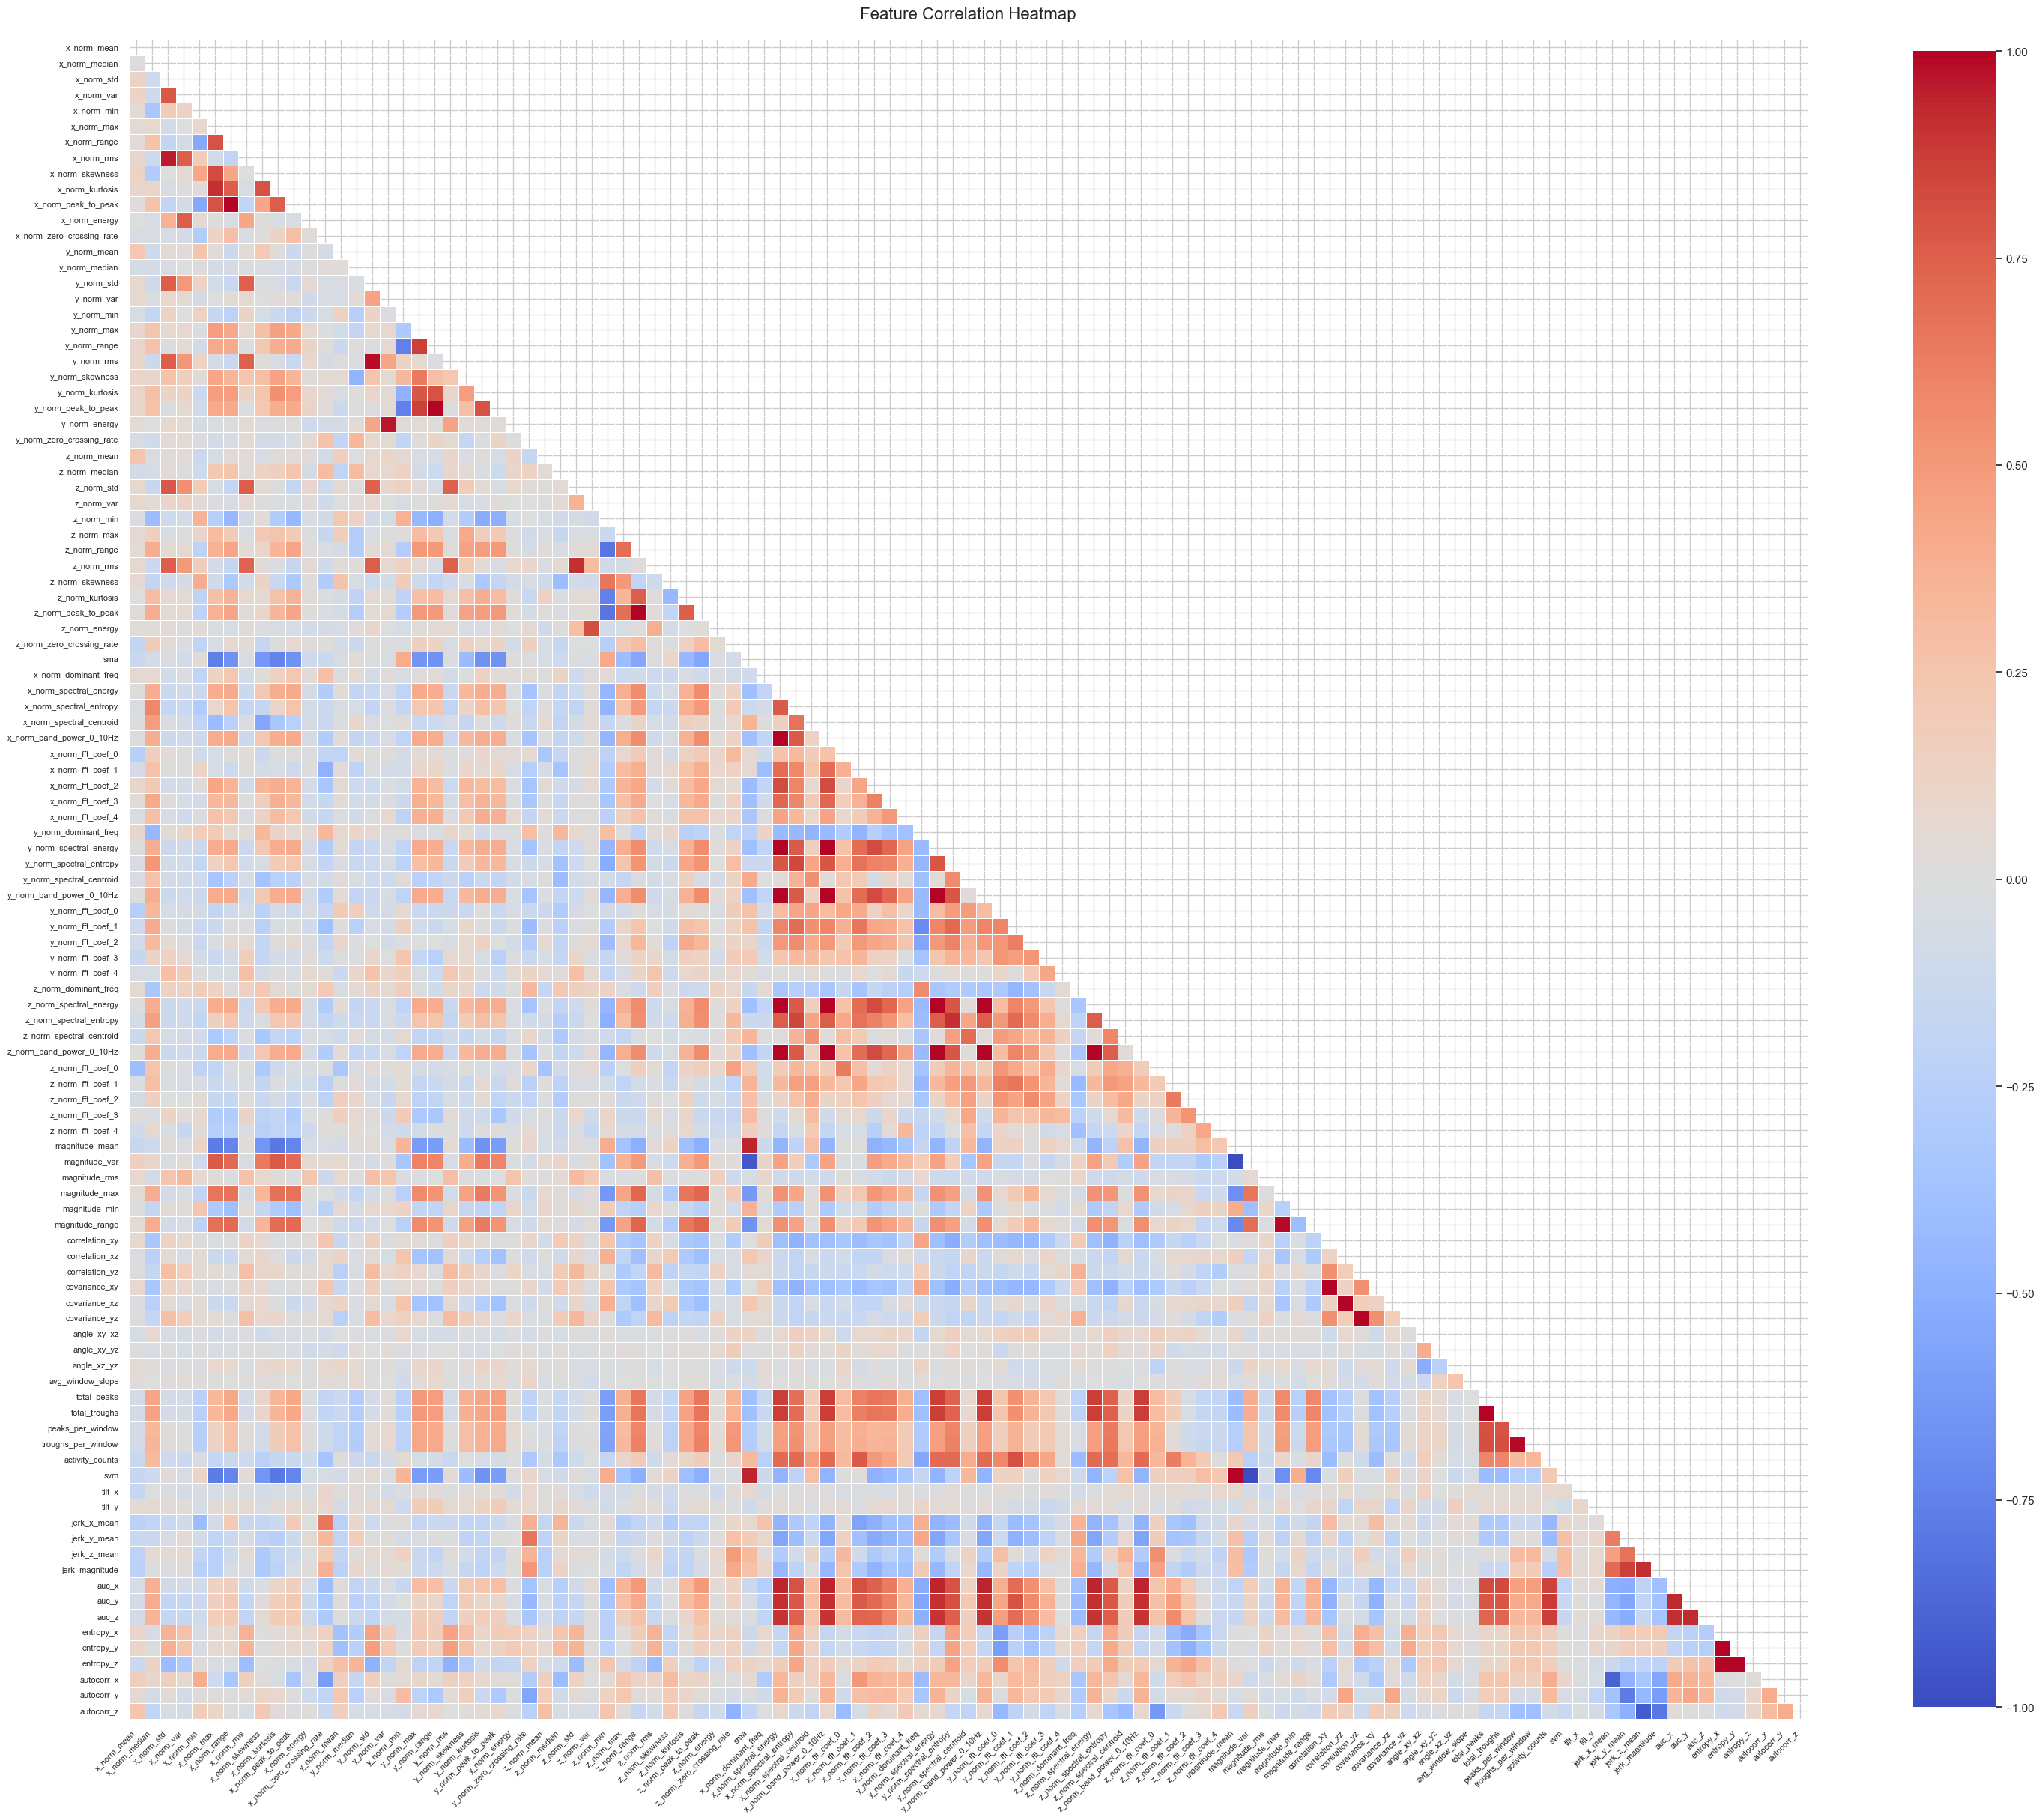


Top 20 Highest Feature Correlations:
              Feature1               Feature2  Correlation
             entropy_y              entropy_z          1.0
             entropy_x              entropy_y          1.0
             entropy_y              entropy_x          1.0
             entropy_z              entropy_y          1.0
   y_norm_peak_to_peak           y_norm_range          1.0
          x_norm_range    x_norm_peak_to_peak          1.0
   z_norm_peak_to_peak           z_norm_range          1.0
   x_norm_peak_to_peak           x_norm_range          1.0
          y_norm_range    y_norm_peak_to_peak          1.0
          z_norm_range    z_norm_peak_to_peak          1.0
                   svm         magnitude_mean          1.0
        magnitude_mean                    svm          1.0
             entropy_z              entropy_x          1.0
             entropy_x              entropy_z          1.0
y_norm_spectral_energy x_norm_spectral_energy          1.0
x_norm_spectral_en

In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Load the dataset
df = pd.read_csv('all_features.csv')

# Extract character names from file names
df['character'] = df['file_name'].str.split('_').str[0]

# Prepare features - drop non-feature columns
features = df.drop(['file_name', 'char_name', 'character'], axis=1)

# Calculate correlation matrix
corr_matrix = features.corr()

# Set up the matplotlib figure
plt.figure(figsize=(30, 28))

# Create a mask to hide upper triangle (optional)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Create heatmap with proper alignment
heatmap = sns.heatmap(
    corr_matrix, 
    mask=mask,  # Remove if you want full matrix
    cmap='coolwarm', 
    vmin=-1, 
    vmax=1,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
    annot=False,  # Set to True if you want values in cells
    fmt=".2f"     # Format for annotations
)

# Rotate x-axis labels for better readability
heatmap.set_xticklabels(
    heatmap.get_xticklabels(),
    rotation=45,
    horizontalalignment='right',
    fontsize=8
)

# Rotate y-axis labels
heatmap.set_yticklabels(
    heatmap.get_yticklabels(),
    rotation=0,
    fontsize=8
)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Title
plt.title('Feature Correlation Heatmap', fontsize=16, pad=20)

# Save high-quality image
plt.savefig('feature_correlation_heatmap.png', dpi=300, bbox_inches='tight')

# Show plot
plt.show()

# For better analysis, let's identify high correlations
high_corr = corr_matrix.abs().stack().reset_index()
high_corr.columns = ['Feature1', 'Feature2', 'Correlation']
high_corr = high_corr[high_corr['Feature1'] != high_corr['Feature2']]  # Remove self-correlations
high_corr = high_corr.sort_values('Correlation', ascending=False)

# Print top 20 highest correlations
print("\nTop 20 Highest Feature Correlations:")
print(high_corr.head(20).to_string(index=False))